In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

train = pd.read_csv("C:\\Users\\user\\AnacondaProjects\\Sberbank\\train.csv", parse_dates=['timestamp'])
test =  pd.read_csv("C:\\Users\\user\\AnacondaProjects\\Sberbank\\test.csv", parse_dates=['timestamp'])
macro = pd.read_csv("C:\\Users\\user\\AnacondaProjects\\Sberbank\\macro.csv", parse_dates=['timestamp'])

#selecting only important macro columns
macro = macro[["timestamp","balance_trade","balance_trade_growth","eurrub","average_provision_of_build_contract","micex_rgbi_tr","micex_cbi_tr","deposits_rate","mortgage_value","mortgage_rate","income_per_cap","rent_price_4+room_bus","museum_visitis_per_100_cap","apartment_build"]]

y_train = train['price_doc']
id_test = test['id']

train.drop(['id', 'price_doc'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

# Build all_data = (train+test).join(macro)
num_train = len(train)
all_data = pd.concat([train, test])
all_data = all_data.join(macro, on='timestamp', rsuffix='_macro')

# Add month-year
month_year = (all_data.timestamp.dt.month + all_data.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
all_data['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (all_data.timestamp.dt.weekofyear + all_data.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
all_data['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Creating Apartment Name Feature
all_data['apartment_name'] = pd.factorize(all_data.sub_area + all_data['metro_km_avto'].astype(str))[0]

#cleaning of full_sq
all_data.loc[((all_data["full_sq"]<=6) | (all_data["full_sq"]>300)) & (all_data["life_sq"]>=6) & (all_data["life_sq"]<300) & ((all_data["full_sq"]>= all_data["life_sq"]*15) | ((all_data["full_sq"]>=0) & (all_data["full_sq"]<all_data["life_sq"]))),"full_sq"]=all_data[((all_data["full_sq"]<=6) | (all_data["full_sq"]>300)) & (all_data["life_sq"]>=6) & (all_data["life_sq"]<300) & ((all_data["full_sq"]>= all_data["life_sq"]*15) | ((all_data["full_sq"]>=0) & (all_data["full_sq"]<all_data["life_sq"])))].life_sq
g_Apartment_col=all_data.groupby('apartment_name')['full_sq'].agg(['mean','median','count']).reset_index()
g_Apartment_col.columns= ['apartment_name','full_sq_mean','full_sq_median','apartment_count'] 
all_data=all_data.merge(g_Apartment_col, how='left')
all_data.loc[((all_data["full_sq"]<=6) | (all_data["full_sq"]>300)) & (all_data.apartment_count>3),"full_sq"]=all_data[((all_data["full_sq"]<=6) | (all_data["full_sq"]>300)) & (all_data.apartment_count>3)].full_sq_mean

all_data.drop("full_sq_median", axis=1, inplace=True)
all_data.drop("full_sq_mean", axis=1, inplace=True)

# Remove timestamp column (may overfit the model in train)
all_data.drop(['timestamp', 'timestamp_macro'], axis=1, inplace=True)

# cleaning price_doc
train = all_data[:num_train]
test  = all_data[num_train:]

train = pd.concat((train,y_train),axis=1)
train["prize_per_sqrmtr"]=train.price_doc/train.full_sq

# grouping by price_doc
g_Apartment_col=train.groupby('apartment_name')['prize_per_sqrmtr'].agg(['mean','std']).reset_index()
g_Apartment_col.columns= ['apartment_name','pps_mean','pps_std'] 
train=train.merge(g_Apartment_col, how='left')
# change value if more than 4 sigma
train.loc[(train.prize_per_sqrmtr > train.pps_mean + (4*train.pps_std)) | (train.prize_per_sqrmtr < train.pps_mean - (4*train.pps_std)),"prize_per_sqrmtr"]=train[(train.prize_per_sqrmtr > train.pps_mean + (4*train.pps_std)) | (train.prize_per_sqrmtr < train.pps_mean - (4*train.pps_std))].pps_mean
# grouping by sub_area
g_Apartment_col=train.groupby('sub_area')['prize_per_sqrmtr'].agg(['mean']).reset_index()
g_Apartment_col.columns= ['sub_area','sa_mean'] 
train=pd.merge(train, g_Apartment_col, how='left', on='sub_area')
# Change if out of range
train.loc[ (train.prize_per_sqrmtr>=600000) | (train.prize_per_sqrmtr<=10000) ,"prize_per_sqrmtr"]= train[(train.prize_per_sqrmtr>=600000) | (train.prize_per_sqrmtr<=18418)].sa_mean
train["price_doc"]=train.prize_per_sqrmtr*train.full_sq
y_train = train['price_doc'].values
# Dropping grouping columns
train.drop(['pps_mean','pps_std','sa_mean','prize_per_sqrmtr','price_doc'], axis=1, inplace=True)

all_data = pd.concat([train, test])

# cleaning life_sq
all_data.loc[(all_data.life_sq.isnull()) | (all_data.life_sq<6) | (all_data.life_sq>all_data.full_sq) | (all_data.life_sq>224),"life_sq"] =all_data[(all_data.life_sq.isnull()) | (all_data.life_sq<6) | (all_data.life_sq>all_data.full_sq) | (all_data.life_sq>224)].full_sq/1.66

# cleaning floor
all_data.loc[(all_data.floor>48),"floor"]=np.NaN

# cleaning max_floor
g_Apartment_col=all_data.groupby('apartment_name')['floor'].agg(['max']).reset_index()
g_Apartment_col.columns= ['apartment_name','apartment_floor_max'] 
all_data=all_data.merge(g_Apartment_col, how='left')
all_data.loc[((all_data.max_floor.isnull()) | (all_data.max_floor>48)) & (all_data.apartment_count>3),"max_floor"] = all_data[((all_data.max_floor.isnull()) | (all_data.max_floor>48)) & (all_data.apartment_count>3)].apartment_floor_max
all_data.drop(['apartment_floor_max'], axis=1, inplace=True)
all_data.loc[((all_data.max_floor.isnull()) | (all_data.floor>0)),"max_floor"]=all_data[(all_data.max_floor.isnull()) | (all_data.floor>0)].floor+1

# cleaning build_year
g_Apartment_col=all_data.groupby('apartment_name')['build_year'].agg(['median']).reset_index()
g_Apartment_col.columns= ['apartment_name','byear_mean']
all_data=pd.merge(all_data, g_Apartment_col, how='left', on='apartment_name')
all_data.loc[(all_data.build_year<1950) | (all_data.build_year>2020) , "build_year"]=all_data[(all_data.build_year<1950) | (all_data.build_year>2020)].byear_mean
all_data.drop(['byear_mean'], axis=1, inplace=True)

# cleaning num_room
g_Apartment_col=all_data.groupby('apartment_name')['num_room'].agg(['median']).reset_index()
g_Apartment_col.columns= ['apartment_name','nrmedian']
all_data=pd.merge(all_data, g_Apartment_col, how='left', on='apartment_name')
all_data.loc[((all_data.num_room>=7) & (all_data.full_sq<100)) | (all_data.num_room==0) | (all_data.num_room.isnull()),"num_room"]=all_data[((all_data.num_room>=7) & (all_data.full_sq<100)) | (all_data.num_room==0) | (all_data.num_room.isnull())].nrmedian
all_data.drop(['nrmedian'], axis=1, inplace=True)

all_data['rel_kitch_sq'] = all_data['kitch_sq'] / all_data['life_sq'].astype(float)


# cleaning kitch_sq
g_Apartment_col=all_data.groupby('apartment_name')['rel_kitch_sq'].agg(['median']).reset_index()
g_Apartment_col.columns= ['apartment_name','rksmedian']
all_data=pd.merge(all_data, g_Apartment_col, how='left', on='apartment_name')
all_data.loc[((all_data.rel_kitch_sq>1) | (all_data.kitch_sq==0) |(all_data.kitch_sq>60) | (all_data.kitch_sq.isnull())) & (all_data.apartment_count>=5),"kitch_sq" ]=all_data[((all_data.rel_kitch_sq>1) | (all_data.kitch_sq==0) |(all_data.kitch_sq>60) | (all_data.kitch_sq.isnull())) & (all_data.apartment_count>=5)].life_sq * all_data[((all_data.rel_kitch_sq>1) | (all_data.kitch_sq==0) |(all_data.kitch_sq>60) | (all_data.kitch_sq.isnull())) & (all_data.apartment_count>=5)].rksmedian
all_data.loc[(all_data.rel_kitch_sq>1) | (all_data.kitch_sq==0) |(all_data.kitch_sq>60) | (all_data.kitch_sq.isnull()),"kitch_sq"]=all_data[(all_data.rel_kitch_sq>1) | (all_data.kitch_sq==0) |(all_data.kitch_sq>60) | (all_data.kitch_sq.isnull())].life_sq * 0.23
all_data.drop(['rksmedian'], axis=1, inplace=True)


# cleaning state
g_Apartment_col=all_data[all_data.state>=0].groupby('apartment_name')['state'].agg(['median','mean']).reset_index()
g_Apartment_col.columns= ['apartment_name','state_median','state_mean']
all_data=pd.merge(all_data, g_Apartment_col, how='left', on='apartment_name')
all_data.loc[((all_data.state.isnull())|(all_data.state>4))&(all_data.apartment_count>=5)&(all_data.state_median>=0) ,"state"]=all_data[((all_data.state.isnull())|(all_data.state>4))&(all_data.apartment_count>=5) & (all_data.state_median>=0)].state_median.astype(int)
all_data.drop(['state_median'], axis=1, inplace=True)
all_data.drop(['state_mean'], axis=1, inplace=True)


# cleaning material
g_Apartment_col=all_data[all_data.material>=0].groupby('apartment_name')['material'].agg(['median','mean']).reset_index()
g_Apartment_col.columns= ['apartment_name','mat_median','mat_mean']
all_data=pd.merge(all_data, g_Apartment_col, how='left', on='apartment_name')
all_data.loc[((all_data.material.isnull())|(all_data.material>6))&(all_data.apartment_count>=5)&(all_data.mat_median>=0) ,"material"]=all_data[((all_data.material.isnull())|(all_data.material>6))&(all_data.apartment_count>=5) & (all_data.mat_median>=0)].mat_median.astype(int)
all_data.drop(['mat_median'], axis=1, inplace=True)
all_data.drop(['mat_mean'], axis=1, inplace=True)
all_data.drop(['apartment_name'], axis=1, inplace=True)

all_data['rel_floor'] = all_data['floor'] / all_data['max_floor'].astype(float)
all_data['rel_kitch_sq'] = all_data['kitch_sq'] / all_data['full_sq'].astype(float)


from sklearn import preprocessing 
#convert objects / non-numeric data types into numeric
for f in all_data.columns:
    if all_data[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(all_data[f].values)) 
        all_data[f] = lbl.transform(list(all_data[f].values))
        
X_train = all_data[:num_train]
X_test = all_data[num_train:]

df_columns = all_data.columns

In [33]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1,
    'booster' :'gbtree',
    'tuneLength': 3,
    'min_child_weight' : 25
}

dtrain = xgb.DMatrix(X_train, y_train, feature_names=df_columns)
dtest = xgb.DMatrix(X_test, feature_names=df_columns)

cv_result = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=20, show_stdv=False)

[0]	train-rmse:8.20159e+06	test-rmse:8.20611e+06
[20]	train-rmse:3.92472e+06	test-rmse:4.03664e+06
[40]	train-rmse:2.75281e+06	test-rmse:2.96973e+06
[60]	train-rmse:2.4533e+06	test-rmse:2.72944e+06
[80]	train-rmse:2.34888e+06	test-rmse:2.66034e+06
[100]	train-rmse:2.28695e+06	test-rmse:2.62576e+06
[120]	train-rmse:2.24157e+06	test-rmse:2.60517e+06
[140]	train-rmse:2.20589e+06	test-rmse:2.59383e+06
[160]	train-rmse:2.17737e+06	test-rmse:2.58634e+06
[180]	train-rmse:2.15365e+06	test-rmse:2.5816e+06
[200]	train-rmse:2.12895e+06	test-rmse:2.57472e+06
[220]	train-rmse:2.10685e+06	test-rmse:2.57037e+06
[240]	train-rmse:2.08632e+06	test-rmse:2.56565e+06
[260]	train-rmse:2.06518e+06	test-rmse:2.56287e+06
[280]	train-rmse:2.04363e+06	test-rmse:2.55795e+06
[300]	train-rmse:2.02096e+06	test-rmse:2.55563e+06
[320]	train-rmse:2.00358e+06	test-rmse:2.5525e+06
[340]	train-rmse:1.98482e+06	test-rmse:2.54873e+06
[360]	train-rmse:1.96706e+06	test-rmse:2.54729e+06
[380]	train-rmse:1.94615e+06	test-rmse:2

In [34]:
%matplotlib inline

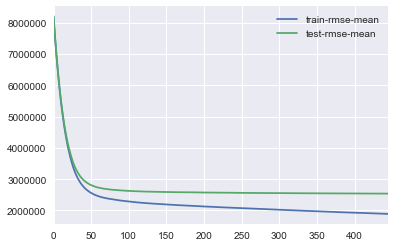

In [35]:
num_boost_rounds = len(cv_result)
cv_result[['train-rmse-mean', 'test-rmse-mean']].plot()

In [36]:
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

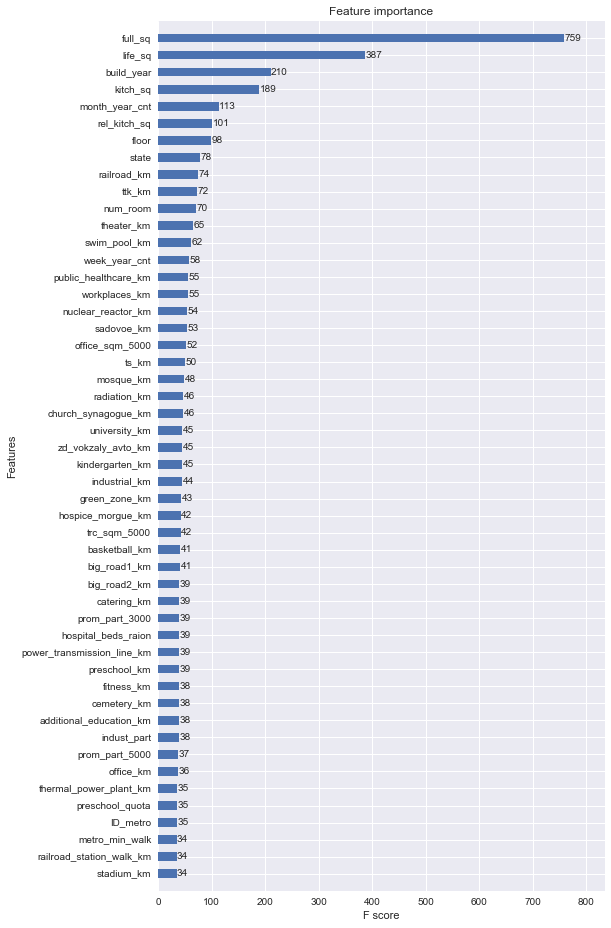

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

In [38]:
x_pred = model.predict(dtrain)

In [39]:
def rmsle(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))

In [40]:
rmsle(x_pred,y_train)

0.43389373707147588

In [41]:
y_pred = model.predict(dtest)

In [42]:
df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred })
df_sub.to_csv('subxgb.csv', index=False)

In [43]:
x_pred

array([  5330264.5,   5306147. ,   4980178. , ...,   5387871.5,
        10901495. ,   6028644. ], dtype=float32)

In [13]:
train_pred = pd.DataFrame(data=x_pred)

In [14]:
import seaborn as sns

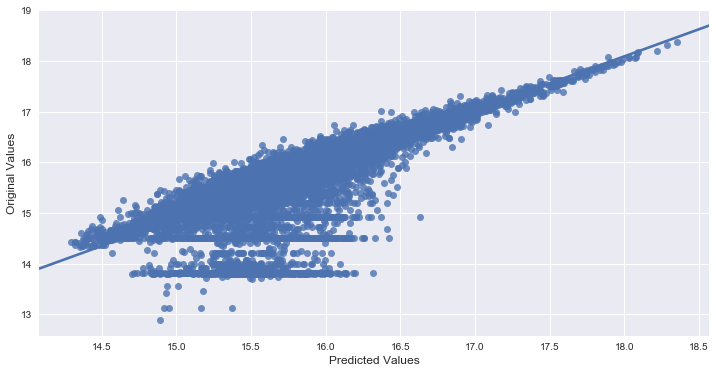

In [15]:
plt.figure(figsize=(12,6))
sns.regplot(x=(np.log1p(train_pred[0])) ,y=np.log1p(y_train))
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Original Values', fontsize=12)
plt.show()

In [44]:
df_y_train = pd.DataFrame(data=y_train)

In [45]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline

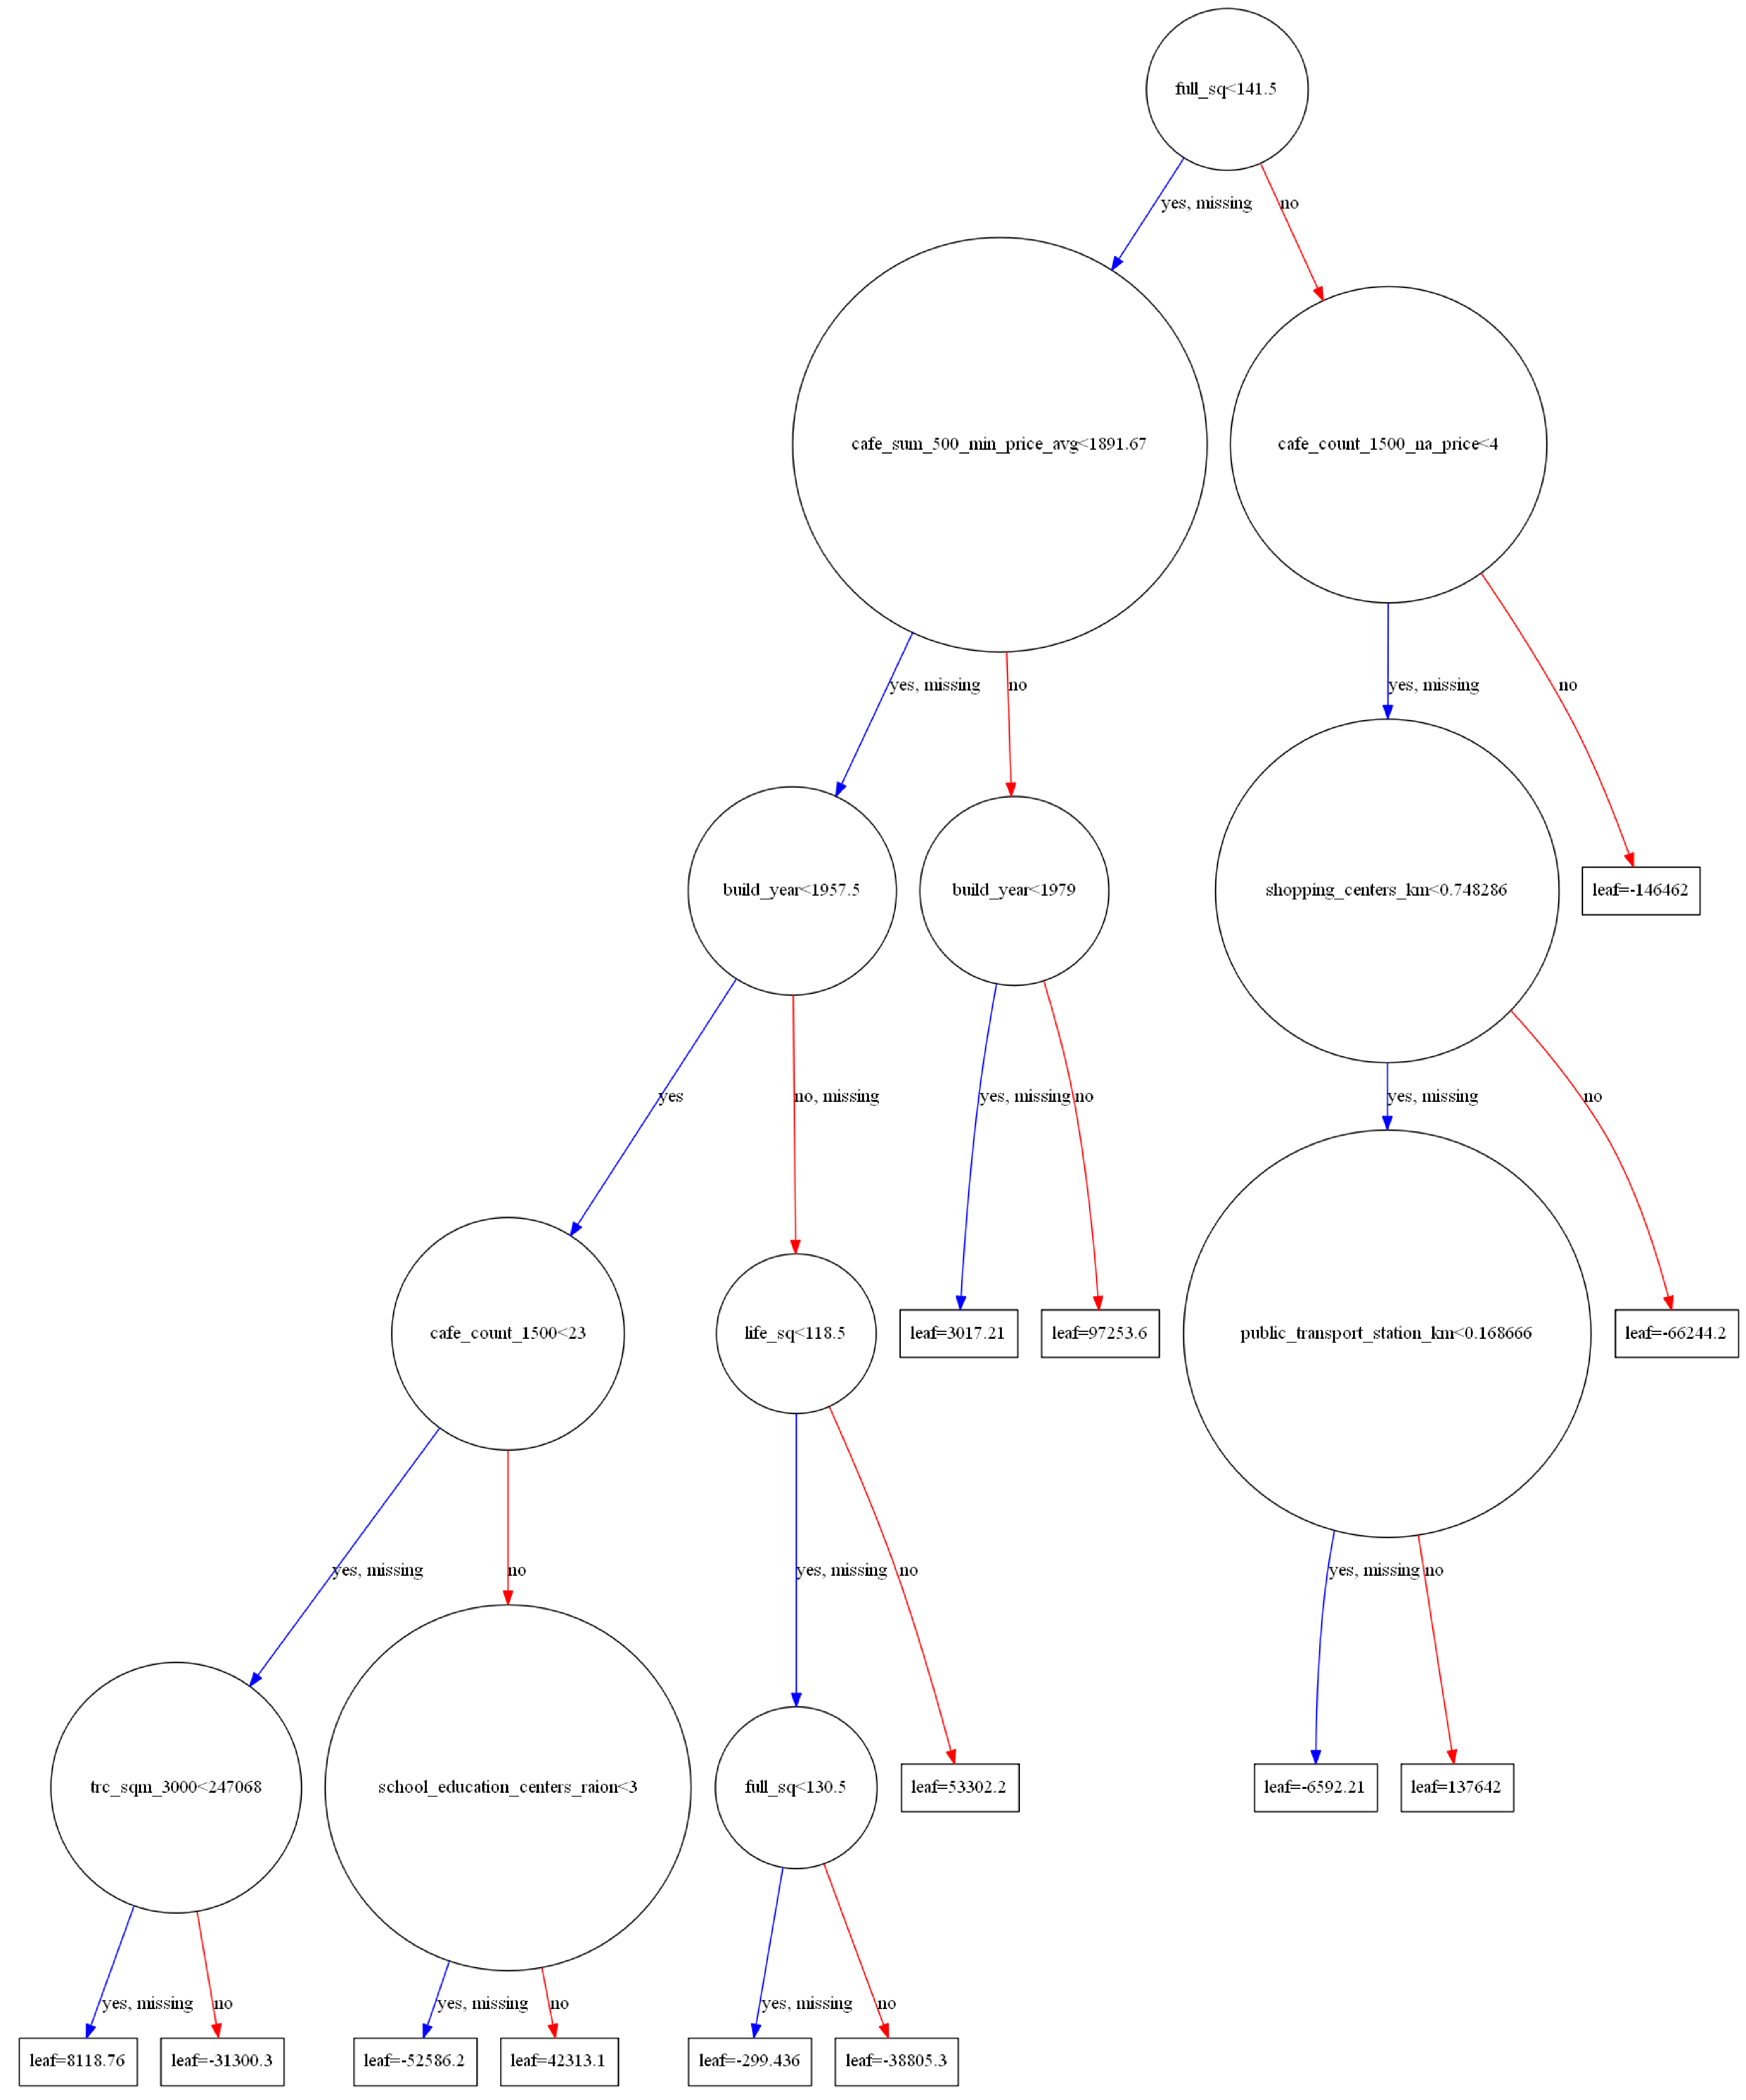

In [57]:
##set up the parameters
rcParams['figure.figsize'] = 100,100
plot_tree(model, num_trees=445)

In [19]:
X_test

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,...,mortgage_rate,income_per_cap,rent_price_4+room_bus,museum_visitis_per_100_cap,apartment_build,month_year_cnt,week_year_cnt,apartment_count,rel_kitch_sq,rel_floor
30471,39.00,20.700000,2.0,3.0,1.0,1998.0,1.0,8.900000,3.0,0,...,NaN,NaN,NaN,NaN,NaN,396,80,3,0.228205,0.666667
30472,79.20,47.710843,8.0,9.0,1.0,2015.0,3.0,1.000000,1.0,1,...,NaN,NaN,NaN,NaN,NaN,396,80,31,0.012626,0.888889
30473,40.50,25.100000,3.0,4.0,2.0,1960.0,2.0,4.800000,2.0,0,...,NaN,NaN,NaN,NaN,NaN,396,80,2,0.118519,0.750000
30474,62.80,36.000000,17.0,18.0,1.0,2016.0,2.0,8.280000,3.0,1,...,NaN,NaN,NaN,NaN,NaN,396,80,8,0.131847,0.944444
30475,40.00,40.000000,17.0,18.0,1.0,0.0,1.0,1.000000,1.0,1,...,NaN,NaN,NaN,NaN,NaN,396,80,331,0.025000,0.944444
30476,48.43,29.174699,21.0,22.0,1.0,2015.0,1.0,1.000000,1.0,1,...,NaN,NaN,NaN,NaN,NaN,396,80,39,0.020648,0.954545
30477,38.80,23.373494,15.0,16.0,1.0,NaN,1.0,1.000000,1.0,1,...,NaN,NaN,NaN,NaN,NaN,396,80,297,0.025773,0.937500
30478,43.10,25.963855,5.0,6.0,1.0,NaN,1.0,0.495402,1.0,1,...,NaN,NaN,NaN,NaN,NaN,396,80,63,0.011494,0.833333
30479,45.40,28.500000,9.0,10.0,5.0,1972.0,2.0,6.000000,2.0,0,...,NaN,NaN,NaN,NaN,NaN,396,80,3,0.132159,0.900000
30480,43.30,43.300000,7.0,8.0,1.0,1.0,1.0,1.000000,1.0,1,...,NaN,NaN,NaN,NaN,NaN,396,80,70,0.023095,0.875000
